# Data extraction and processing
see here for API tutorial on selecting data
http://docs.synapse.org/rest/org/sagebionetworks/repo/web/controller/TableExamples.html

In [4]:
# %run sc2FitModels.py
# %load sc2FitModels.py
""" Score a feature matrix on either tremor, dyskinesia, or bradykinesia tasks.

See function `score` if calling from within Python.
Pass the -h flag if calling from the command line.

Author: Phil Snyder (phil [dot] snyder [at] sagebase [dot] org)
"""
from __future__ import print_function, division
import numpy as np
import pandas as pd
import synapseclient as sc
import argparse
from nonLinearInterpAUPRC import getAUROC_PR
from sklearn.metrics.base import _average_binary_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

TRAINING_TABLE = "syn10495809"
INDEX_COL = "dataFileHandleId"
CATEGORY_WEIGHTS = {
        'tremor':[896, 381, 214, 9, 0],
        'dyskinesia':[531, 129], # no weighting is done when
        'bradykinesia':[990, 419]} # scoring the binary cases
SUBMISSION_TEMPLATES = {
        'tremor': 'syn11315931',
        'dyskinesia': 'syn11315929',
        'bradykinesia': 'syn11315927'}

syn = sc.login()
np.random.seed(0) # reproducible results for stochastic training elements

def read_args():
    """ Relevant only if calling from command line. """
    parser = argparse.ArgumentParser(
            description="Score an L-Dopa Submission file (AUPRC).")
    parser.add_argument("phenotype",
            help="One of 'tremor', 'dyskinesia', or 'bradykinesia'")
    parser.add_argument("submission",
            help="filepath to submissions file")
    args = parser.parse_args()
    return args

def read_data(path, phenotype):
    """ Read in training data from `path` and fetch targets for `phenotype`.

    Parameters
    ----------
    path (str) - filepath to submission feature matrix
    phenotype (str) - one of 'tremor', 'dyskinesia', 'bradykinesia'

    Returns
    -------
    train_X, train_y (numpy.ndarray)
    """
    df = pd.read_csv(path, index_col=INDEX_COL, header=0)
    train_table = get_table(TRAINING_TABLE)
    train = df.join(
            train_table[['tremorScore', 'dyskinesiaScore', 'bradykinesiaScore']], how='inner')
    submission_template = syn.get(SUBMISSION_TEMPLATES[phenotype])
    submission_template = pd.read_csv(submission_template.path, index_col='dataFileHandleId')
    to_keep = submission_template.index
    train = train.loc[to_keep.intersection(train.index)]
    train_X = train.drop(['tremorScore', 'dyskinesiaScore', 'bradykinesiaScore'],
            axis=1).values
    train_y = train["{}Score".format(phenotype)].values
    return train_X, train_y

def get_table(synId):
    """ Returns all rows from a Synapse Table as a DataFrame """
    q = syn.tableQuery("select * from {}".format(synId))
    df = q.asDataFrame()
    df = df.set_index(INDEX_COL, drop=True)
    return df

def train_ensemble(X, y):
    """ Trains a soft-voting ensemble consisting of a random forest,
    logistic regression with L2 regularization, and support vector
    machine (RBF kernel).

    Parameters
    ----------
    X (numpy.ndarray) - feature matrix
    y (numpy.ndarray) - target array

    Returns
    -------
    ensemble (VotingClassifier)
    """
    rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=500))
    lr = OneVsRestClassifier(LogisticRegressionCV())
    svm = OneVsRestClassifier(SVC(probability=True))
    ensemble = VotingClassifier(
            estimators=[('rf', rf), ('lr', lr), ('svm', svm)], voting='soft')
    ensemble.fit(X, y)
    return ensemble

def getNonLinearInterpAupr(X, y, y_labels, clf):
    """ Given data, targets, a list of unique target values, and an
    sklearn classifier, return the weighted non-linear interpolated AUPRC.

    Parameters
    ----------
    X (np.ndarray) - feature matrix
    y (np.ndarray) - target values
    y_labels (np.ndarray) - unique list of target values (in case missing target
        values in test set)
    clf (sklearn.base.BaseEstimator) - an sklearn object with method `predict_proba`
    average (str, default 'micro') - one of 'micro', 'macro', 'samples', 'weighted'
        (see http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
    """
    n_classes = len(y_labels)
    if n_classes > 2:
        y_true = label_binarize(y, y_labels)
    else:
        y_true = y
    y_score = clf.predict_proba(X) if n_classes > 2 else clf.predict_proba(X).T[1]
    return nonLinearInterpAupr(y_score, y_true)

def nonLinearInterpAupr(y_score, y_true):
    """ Given ground truth targets and predicted targets, calculates
    weighted non-linear interpolated AUPRC.

    Parameters
    ----------
    y_true (list-like) - actual target values
    y_score (list-like) - predicted target values
    average (str, default 'micro') - one of 'micro', 'macro', 'samples', 'weighted'
        (see http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
    sample_weight (list-like, optional) - of shape (n_samples,)

    Returns
    -------
    results (list), y_score (np.ndarray), y_true (np.ndarray)
    """
    if y_score.ndim > 1:
        sub_stats = pd.DataFrame(np.concatenate((y_score, y_true), axis=1),
                dtype='float64')
    else:
        sub_stats = pd.DataFrame(np.array([y_score, y_true]).T)
    results = getAUROC_PR(sub_stats)
    return results, y_score, y_true

def getWeightedMean(phenotype, scores):
    numer = 0
    denom = sum(CATEGORY_WEIGHTS[phenotype])
    for w, s in zip(CATEGORY_WEIGHTS[phenotype], scores):
        if pd.notnull(s):
            numer += w * s
    return numer / denom

def calculatePVal(y_score, y_true, trueAupr, phenotype):
    """ Calculate P-value for a set of predictions.

    Parameters
    ---------
    y_score (np.ndarray) - predicted targets
    y_true (np.ndarray) - actual targets
    trueAupr (float, optional) - actual AUPRC
    phenotype (str) - one of 'tremor', 'dyskinesia', 'bradykinesia'

    Returns
    -------
    pval (float)
    """
    auprs = []
    n_iterations = 10
    for i in range(n_iterations):
        np.random.shuffle(y_score)
        results = nonLinearInterpAupr(y_score, y_true)
        if phenotype == 'tremor':
            weighted_results = getWeightedMean(phenotype, results)
        else:
            weighted_results = results[0]
        auprs.append(weighted_results)
    return sum([a > trueAupr for a in auprs]) / n_iterations

def score(phenotype, submission):
    """ Returns AUPRC, predicted and actual targets on
    training data given a feature matrix.

    Parameters
    ----------
    phenotype (str) - one of 'tremor', 'dyskinesia', 'bradykinesia'
    submission (str) - filepath to submissions file

    Returns
    -------
    aupr (float)
    pval (float)
    y_score (np.ndarray)
    y_true (np.ndarray)
    """
    train_X, train_y = read_data(submission, phenotype)
    ensemble = train_ensemble(train_X, train_y)
    results, y_score, y_true = getNonLinearInterpAupr(train_X, train_y,
            np.arange(len(CATEGORY_WEIGHTS[phenotype])), ensemble)
    if phenotype == 'tremor':
        weighted_aupr = getWeightedMean(phenotype, results)
    else:
        weighted_aupr = results[0]
    # pval calculation is very slow
    #pval = calculatePVal(y_score, y_true, weighted_aupr, phenotype)
    return weighted_aupr, y_score, y_true

# def main():
#     """ For use on command line. Only returns AUPRC"""
#     args = read_args()
#     aupr, y_score, y_true = score(args.phenotype, args.submission)
#     print("AUPRC: {}".format(aupr))
#     return aupr

# if __name__ == "__main__":
#     main()


Welcome, Luca Lonini!



In [5]:
import synapseclient

In [6]:
syn=synapseclient.login()

Welcome, Luca Lonini!



In [605]:
import pandas as pd
import json
import numpy as np
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt
import nolds
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots

In [4]:
syntable = syn.tableQuery("SELECT * from syn10495809")

In [5]:
table = syntable.asDataFrame()

In [6]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5168 entries, 25819_22 to 30986_23
Data columns (total 11 columns):
dataFileHandleId     5168 non-null int64
device               5168 non-null object
patient              5168 non-null object
session              5168 non-null int64
site                 5168 non-null object
task                 5168 non-null object
visit                5168 non-null int64
deviceSide           5168 non-null object
tremorScore          3667 non-null float64
dyskinesiaScore      1556 non-null float64
bradykinesiaScore    3016 non-null float64
dtypes: float64(3), int64(3), object(5)
memory usage: 484.5+ KB


In [7]:
table.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1.0,NaN,1.0
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1.0,NaN,1.0
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2.0,NaN,1.0
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1.0,NaN,1.0
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0.0,NaN


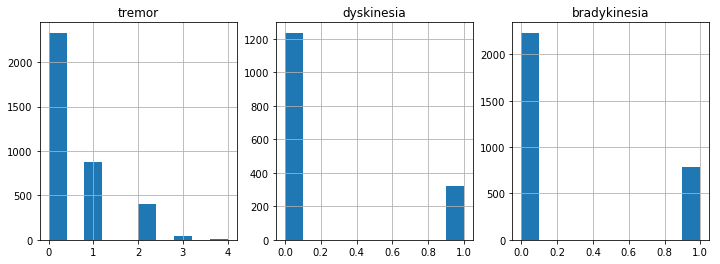

In [8]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
plt.title('tremor')
table.tremorScore.hist()
ax = fig.add_subplot(132)
table.dyskinesiaScore.hist()
plt.title('dyskinesia')
ax = fig.add_subplot(133)
table.bradykinesiaScore.hist()
plt.title('bradykinesia')

In [9]:
table.task.unique()

array(['drnkg', 'fldng', 'ftnl1', 'ftnl2', 'ftnr1', 'ftnr2', 'ntblt',
       'orgpa', 'raml1', 'raml2', 'ramr1', 'ramr2'], dtype=object)

In [10]:
sum(table.tremorScore==4)

12

# Dyskinesia

In [880]:
q_dysk_train = syn.tableQuery("SELECT * from syn10495809 where dyskinesiaScore is not null")
paths_train = syn.downloadTableColumns(q_dysk_train,'dataFileHandleId')

In [881]:
df_train_dysk = q_dysk_train.asDataFrame()

In [884]:
df_train_dysk['path']=df_train_dysk.dataFileHandleId.astype(str).map(paths_train)

In [885]:
df_train_dysk.head(2)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0,NaN,/Users/luca/Projects/DREAM_PD/Data/39/17286039...
25825_22,17286045,GENEActiv,13_BOS,1,Boston,ftnl2,1,Right,NaN,0,NaN,/Users/luca/Projects/DREAM_PD/Data/45/17286045...


In [886]:
df_train = df_train_dysk

In [887]:
row = 0
nans_found=0; n_empty=0
Features = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on entire recording
        try:
            F,flist = feature_extraction(rawdata)
            Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)

0


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


1000
Elapsed Time:[s] 38.7
Files w nans: 88
Files w 0 non-nan rows 56


In [891]:
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

(1556, 26)


In [893]:
df_feat = pd.DataFrame(data=Features,columns=flist,dtype='float64')
df_feat.index = df_train.index
df_train = pd.concat((df_train,df_feat),axis=1)

In [894]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,...,kurtY,kurtZ,xcor_peakXY,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0,...,0.162701,-0.079857,4.745927,0.734146,0.546572,0.506667,0.503333,0.497778,8.1,0.072784
25825_22,17286045,GENEActiv,13_BOS,1,Boston,ftnl2,1,Right,NaN,0,...,0.134648,-0.026859,1.458933,1.109415,41.765466,0.515556,0.503333,0.496667,6.1,0.058848
25828_22,17286054,Pebble,13_BOS,1,Boston,ftnr1,1,Left,NaN,0,...,7.689771,1.385359,0.359814,0.669308,0.856794,0.505556,0.543333,0.485556,1.3,0.083133
25830_22,17286060,Pebble,13_BOS,1,Boston,ftnr2,1,Left,NaN,0,...,11.841003,3.249798,2.058724,1.980309,0.381623,0.498947,0.521053,0.500000,1.0,0.145483
25835_22,17286076,GENEActiv,13_BOS,1,Boston,raml1,1,Right,NaN,0,...,0.566197,0.002158,1.541055,2.828754,31.930616,0.482105,0.549474,0.557895,5.7,0.515168


In [911]:
X = df_train.copy()
cat_cols = df_train.select_dtypes(['object']).columns
for c in cat_cols:
    X[c]=le.fit_transform(df_train[c])

In [913]:
#drop scores cols
X = X.drop(['tremorScore','dyskinesiaScore','bradykinesiaScore','path'],axis=1)
#drop nans
X=X.dropna()

In [939]:
#normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X.iloc[:,8:]=scaler.fit_transform(X.iloc[:,8:])

In [940]:
X.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,EX,EY,...,kurtY,kurtZ,xcor_peakXY,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel
25823_22,17286039,0,2,1,0,0,1,1,-0.295024,-0.155948,...,-0.360872,-0.366179,-0.048514,-0.032020,-0.177740,0.156770,0.029291,-0.042929,1.964716,-0.667609
25825_22,17286045,0,2,1,0,1,1,1,-0.294555,-0.155654,...,-0.361554,-0.365204,-0.059190,-0.031821,0.641065,0.323521,0.029291,-0.061885,1.084997,-0.812262
25828_22,17286054,1,2,1,0,2,1,0,-0.291026,-0.150657,...,-0.177960,-0.339220,-0.062759,-0.032054,-0.171578,0.135926,0.667479,-0.251452,-1.026329,-0.560191
25830_22,17286060,1,2,1,0,3,1,0,-0.285960,-0.131261,...,-0.077083,-0.304915,-0.057242,-0.031361,-0.181017,0.011959,0.311997,-0.005015,-1.158287,0.086963
25835_22,17286076,0,2,1,0,4,1,1,-0.287749,-0.157567,...,-0.351067,-0.364670,-0.058923,-0.030912,0.445698,-0.303991,0.765446,0.982726,0.909053,3.924082


In [916]:
#only meta features
X_meta = X.iloc[:,1:7]

In [928]:
X_meta['dataFileHandleId'] = X['dataFileHandleId']

In [930]:
X_meta.to_csv('Submission_Dysk_meta.csv',index=False)

In [931]:
%run sc2FitModels.py 'dyskinesia' Submission_Dysk_meta.csv

Welcome, Luca Lonini!

AUPRC: 0.9871336130604139


In [941]:
X.to_csv('Submission_Dysk.csv',index=False)

In [942]:
%run sc2FitModels_LOSOCV.py 'dyskinesia' Submission_Dysk.csv

Welcome, Luca Lonini!

AUPRC: [0.17473357112568672, nan, 0.64130760600690595, nan, 0.75690683126336022, 0.96273329545072728, 0.35635302180995548, 0.33691768312514736, nan, 0.95759631691876423, nan, nan, nan, 0.088568145949117549, 0.042427884615384617, 0.12694342694342695, 0.005208333333333333, nan, 0.099259911942920886]


In [943]:
%run sc2FitModels.py 'dyskinesia' Submission_Dysk.csv

Welcome, Luca Lonini!

AUPRC: 0.9640081852084357


# Bradykinesia

In [8]:
q_brady_train = syn.tableQuery("SELECT * from syn10495809 where bradykinesiaScore is not null")

In [9]:
paths_train = syn.downloadTableColumns(q_brady_train,'dataFileHandleId')

In [553]:
df_train = q_brady_train.asDataFrame()

In [554]:
df_train['path']=df_train.dataFileHandleId.astype(str).map(paths_train)

In [555]:
df_train.head(5)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/28/17286028...
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/30/17286030...
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/34/17286034...
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/36/17286036...
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/42/17286042...


## Train a baseline classifier using the metadata only

In [94]:
len(df_train.patient.unique())

19

In [95]:
X_meta = df_train[['dataFileHandleId','device','patient','session','site','task','visit','deviceSide']]
y_meta = df_train['bradykinesiaScore']

## Encode categorical variables with dummy values

In [96]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [97]:
X_meta.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left


In [98]:
X_meta_copy = X_meta.copy()
cat_cols = X_meta.select_dtypes(['object']).columns
for c in cat_cols:
    X_meta_copy[c]=le.fit_transform(X_meta[c])

In [99]:
X_meta_copy.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide
25819_22,17286028,0,2,1,0,0,1,1
25820_22,17286030,1,2,1,0,0,1,0
25821_22,17286034,0,2,1,0,1,1,1
25822_22,17286036,1,2,1,0,1,1,0
25824_22,17286042,1,2,1,0,2,1,0


In [100]:
X_meta=X_meta_copy

# Make dummy submission file to test score fcn

In [28]:
X_meta.to_csv('DummySubmission.csv',index=False)

In [29]:
%run sc2FitModels.py 'bradykinesia' DummySubmission.csv

Welcome, Luca Lonini!

AUPRC: 0.9898671060750107


## Explore data

dataFileHandleId                                              17286072
device                                                          Pebble
patient                                                         13_BOS
session                                                              1
site                                                            Boston
task                                                             orgpa
visit                                                                1
deviceSide                                                        Left
tremorScore                                                          1
dyskinesiaScore                                                    NaN
bradykinesiaScore                                                    1
path                 /Users/luca/Projects/DREAM_PD/Data/72/17286072...
Name: 25834_22, dtype: object


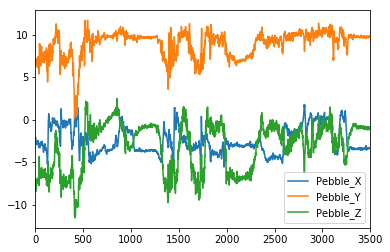

In [101]:
#plot task
idx=9
print(df_train.iloc[idx,:]) 
p1 = df_train.path[idx]
rawdata = pd.read_csv(p1,sep='\t')
rawdata.iloc[:,1:4].plot()

In [ ]:
#durations of tasks
c = 0
Dur = []
for f in df_train.path:
    rawdata = pd.read_csv(f,sep='\t')
    t = rawdata.timestamp
    t = t-t[0]
    rawdata.timestamp = t
    Dur.append(rawdata.timestamp.iloc[-1])
    c+=1
Dur = np.asarray(Dur)

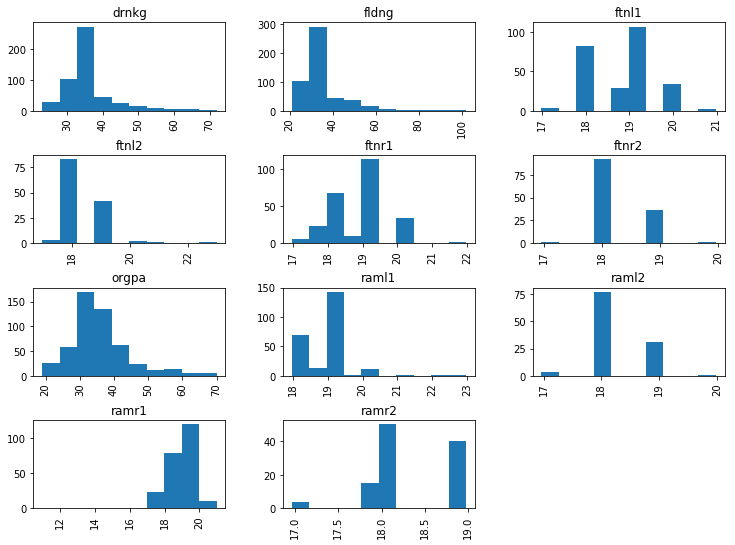

In [103]:
plt.figure(figsize=(12,4))
df_train['Duration']=Dur
ax = df_train.hist(column='Duration',by='task',figsize=(12,9))

In [105]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path,Duration
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/28/17286028...,38.98
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/30/17286030...,38.98
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/34/17286034...,101.98
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/36/17286036...,101.98
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/42/17286042...,17.98


In [124]:
# #display duration based on presence of bradykinesia
# for t in df_train.task.unique():
#     fig = plt.figure()
#     for i in range(2):
#         d = df_train[(df_train['bradykinesiaScore']==i) & (df_train['task']==t)]
#         if ~d.empty:
#             try:
#                 sns.distplot(d['Duration'])
#             except(ZeroDivisionError):
#                 print(d.empty)
#     plt.title(t)

## Clips generation and feature extraction

### Helper fcns

In [804]:
#feature extraction
#INPUT: raw x,y,z accelerometer data (dataframe)
def feature_extraction(rawdata):
    
    #drop time and magnitude feature
    rawdata_wtime = rawdata.copy()
    rawdata=rawdata.iloc[:,1:4]
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel']
    

    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    #extract features on current clip

    #Energy of signal on each axis
    E = np.asarray(np.sum(rawdata**2,axis=0))

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis
    mean = np.asarray(np.mean(rawdata,axis=0))
    var = np.asarray(np.std(rawdata,axis=0))
    sk = skew(rawdata)
    kurt = kurtosis(rawdata)

    #Cross-correlation between axes pairs
    xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
    xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

    xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
    xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

    xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
    xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

    #pack xcorr features
    xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
    xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])

    #Power of FFT between 1-10 Hz
#     Pxx,fft_labels = powerspectra(rawdata_wtime,1,10) #dataframe with power spectra for each axis
#     xfft = np.asarray([Pxx.iloc[:,0].values, Pxx.iloc[:,1].values, Pxx.iloc[:,2].values])
#     xfft = np.reshape(xfft,(1,xfft.size)) #row vector
#     xfft = xfft.reshape(-1)
#     features_list += fft_labels #add fft labels
    
    #Dominant freq and relative magnitude (on acc magnitude)
    Pxx,_ = powerspectra(rawdata_wtime,1,10,nbins=50) #dataframe with power spectra for each axis
    domfreq = np.asarray([Pxx.iloc[:,-1].argmax()]) 
    Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total

    #sample entropy raw data and FFT - COMPUTATIONALLY EXPENSIVE - TAKE OUT FOR NOW
#     sH_raw = []; sH_fft = []
#     for a in range(3):
#         x = rawdata.iloc[:,a]
#         n = len(x) #number of samples in clip
#         Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
#         sH_raw.append(nolds.sampen(x)) #samp entr raw data
#         f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#         sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

    #Assemble features in array
    X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel))
#                 X = X.reshape(1,X.shape[0])
    features.append(X)

    F = np.asarray(features) #feature matrix for all clips from current trial
    return F,features_list

In [760]:
def gen_clips(rawdata,clipsize=5,overlap=0):
    
    len_tol = 0.8   #% of the intended clipsize below which clip is not used
    #reindex time (relative to start)
    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    #create clips data
    deltat = np.median(np.diff(rawdata.timestamp))
    idx = np.arange(0,rawdata.timestamp.iloc[-1],clipsize*(1-overlap))
    clips = []
    for i in idx:
        c = rawdata[(rawdata.timestamp>=i) & (rawdata.timestamp<i+clipsize)]
        if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
            clips.append(c)

    return clips


In [761]:
#returns power spectra of the signal over each channel between min and max freq at given resolution (nbins)
#returns the labels for each bin
#if binavg is True it averages the PSD within bins to reduce PSD noise
def powerspectra(x,fm,fM,nbins=10,relative=False,binavg=True):
    
    #feature labels
    labels=[]
    s = np.linspace(fm,fM,nbins)
    lax = ['X','Y','Z']
    for l in lax:
        for i in s:
            labels.append('fft'+l+str(int(i)))
            
    #signal features
    n = len(x) #number of samples in clip
    Fs = np.nanmean(1/(np.diff(x.timestamp))) #sampling rate in clip
    timestep = 1/Fs 
    freq = np.fft.fftfreq(n,d=timestep) #frequency bins

    #run FFT on each channel 
    x = x.drop('timestamp',axis=1)
    Xf = x.apply(np.fft.fft)
    Xf.index = np.round(freq,decimals=1) #reindex w frequency bin
    Pxx = Xf.apply(np.abs)
    Pxx = Pxx**2 #power spectra
    if relative:
        Pxx = Pxx/np.sum(Pxx,axis=0) #power relative to total
    
    #power spectra between fm-fM Hz
    bin1 = int(timestep*n*fm)
    bin2 = int(timestep*n*fM)
    bins = np.linspace(bin1,bin2,nbins,dtype=int)
#     print(bins/(round(timestep*n)))

    #average power spectra within bins
    if binavg:
        deltab = int(0.5*np.diff(bins)[0]) #half the size of a bin (in samples)
        Pxxm = []
        for i in bins:
            start = int(max(i-deltab,bins[0]))
            end = int(min(i+deltab,bins[-1]))
            Pxxm.append(np.nanmean(Pxx.iloc[start:end,:].values,axis=0))            
        Pxxm = np.asarray(Pxxm)
        Pxx = pd.DataFrame(data=Pxxm,index=Pxx.index[bins],columns=Pxx.columns)
        return Pxx, labels
    
    else:
        return Pxx.iloc[bins,:], labels



In [762]:
#highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
def filter_signal(rawdata,cutoff=0.75,ftype='highpass',order=4):

    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    x = rawdata.iloc[:,1:].values
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate    
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
    b,a = butter(order,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    t = np.expand_dims(t,axis=1)
    rawdatafilt = pd.DataFrame(data=np.hstack((t,xfilt)),columns=rawdata.columns)
    return rawdatafilt


### Test fcns

dataFileHandleId                                              17286084
device                                                          Pebble
patient                                                         13_BOS
session                                                              1
site                                                            Boston
task                                                             raml2
visit                                                                1
deviceSide                                                        Left
tremorScore                                                          2
dyskinesiaScore                                                    NaN
bradykinesiaScore                                                    1
path                 /Users/luca/Projects/DREAM_PD/Data/84/17286084...
Name: 25838_22, dtype: object


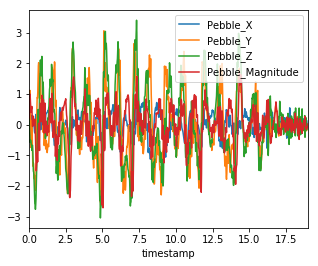

In [805]:
#plot task
idx=11
print(df_train.iloc[idx,:]) 
p1 = df_train.path[idx]
rawdata = pd.read_csv(p1,sep='\t')
rawdata = filter_signal(rawdata,order=2)
ax = rawdata.plot(x='timestamp')

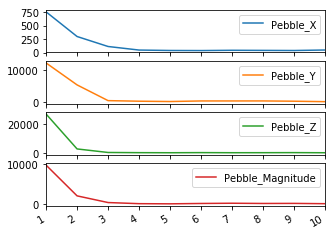

In [749]:
Pxx,fl=powerspectra(rawdata,1,10,nbins=10)
ax = Pxx.plot(subplots=True)

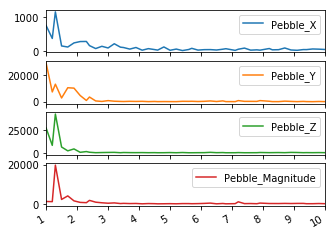

In [750]:
Pxx,fl=powerspectra(rawdata,1,10,nbins=50)
ax = Pxx.plot(subplots=True)

In [792]:
domfreq = np.asarray([Pxx.iloc[:,-1].argmax()])
domfreq

array([ 1.3])

In [803]:
Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum()

array([ 0.47673788])

## Compute features on all rows and time it

#### Test on 1 row

In [806]:
F,flist = feature_extraction(rawdata)

In [807]:
F.shape

(1, 26)

In [809]:
row = 0
nans_found=0; n_empty=0
Features = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on entire recording
        try:
            F,flist = feature_extraction(rawdata)
            Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)

0


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


1000
2000
3000
Elapsed Time:[s] 76.9
Files w nans: 190
Files w 0 non-nan rows 103


In [810]:
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

(3016, 26)


### append feature to df_train

In [811]:
df_feat = pd.DataFrame(data=Features,columns=flist,dtype='float64')
df_feat.index = df_train.index
df_train = pd.concat((df_train,df_feat),axis=1)

In [812]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,...,kurtY,kurtZ,xcor_peakXY,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,...,3.005594,37.937341,10.171132,30.574186,4.866523,0.487692,0.499487,0.499487,1.7,0.039560
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,...,3.009667,3.613391,1.335482,7.076296,1.686165,0.533846,0.493333,0.495897,1.4,0.122879
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,...,15.285717,5.924917,1.450262,0.650105,7.815301,0.502745,0.502941,0.502157,2.3,0.048426
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,...,4.032697,4.244208,1.415601,0.288619,6.536107,0.489020,0.497059,0.500196,1.5,0.095789
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,...,0.859362,0.322129,0.195136,1.345204,0.497435,0.465556,0.472222,0.501111,1.7,0.406246


### Test performance

In [824]:
X = pd.concat((X_meta,df_train.iloc[:,12:]),axis=1)

In [826]:
X.head(3)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,EX,EY,...,kurtY,kurtZ,xcor_peakXY,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel
25819_22,17286028,0,2,1,0,0,1,1,261.944772,66.357233,...,3.005594,37.937341,10.171132,30.574186,4.866523,0.487692,0.499487,0.499487,1.7,0.039560
25820_22,17286030,1,2,1,0,0,1,0,1140.053894,2079.908881,...,3.009667,3.613391,1.335482,7.076296,1.686165,0.533846,0.493333,0.495897,1.4,0.122879
25821_22,17286034,0,2,1,0,1,1,1,2710.009059,2203.722703,...,15.285717,5.924917,1.450262,0.650105,7.815301,0.502745,0.502941,0.502157,2.3,0.048426


In [825]:
X.shape

(3016, 34)

In [837]:
X=X.dropna()

In [838]:
X.to_csv('Submission1.csv',index=False)

In [839]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission1.csv

Welcome, Luca Lonini!

AUPRC: [0.97364174575430207, 0.089678074162617305, 0.98317435444612755, 0.96224627164914089, 0.88201793500057923, 0.98801569100988673, 0.98211388924264609, 0.88953980994775783, 0.25791072640894114, 0.97517051290602819, 0.1991493959703724, 0.25319256343243618, 0.1226020944027876, 0.87344057456019064, 0.081323576865198643, 0.32600614174539366, 0.97264982019855961, 0.018294362613575386, 0.98691666286667235]


In [840]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' DummySubmission.csv

Welcome, Luca Lonini!

AUPRC: [0.96418540805444453, 0.14027760685472601, 0.93497830075740962, 0.95911290159512474, 0.88405791313831983, 0.99019019019019017, 0.99118165784832446, 0.95310487912775166, 0.53794863427354733, 0.98894009216589862, 0.3443364414391421, 0.43842766253874399, 0.20572814485384885, 0.90425993036445451, 0.81553996598639455, 0.48223919859596359, 0.97285450032294607, 0.23109434865900383, 0.98636489479512734]


In [875]:
coldrop=list(X.columns)[1:8]
coldrop.remove('patient')

In [877]:
X_featonly=X.drop(coldrop,axis=1)

In [878]:
X_featonly.to_csv('Featonly.csv',index=False)

In [879]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Featonly.csv

Welcome, Luca Lonini!

AUPRC: [0.92813597493628708, 0.10489913015856153, 0.93836956015802164, 0.95887173606110998, 0.79884693703799836, 0.95417932750479961, 0.87578096294956786, 0.51731107929267139, 0.16323291374897519, 0.89098782593317161, 0.1532074956641859, 0.19316931567203727, 0.093671750656162539, 0.81906306768680603, 0.060397277662888209, 0.35731165553082878, 0.96290579105755925, 0.01161578417073357, 0.97793564316195969]


** Feature computation time on 1 clip **

In [323]:
t1 = time.time()
rawdata = pd.read_csv(f,sep='\t')
print(time.time()-t1)
t1 = time.time()
F,flist = feature_extraction(rawdata)
print(time.time()-t1)


0.003940105438232422
0.009171009063720703


# Extract data for Tremor

In [38]:
q_tremor = syn.tableQuery("SELECT * from syn10495809 where tremorScore is not null")

In [39]:
Train_tremor = q_tremor.asDataFrame()

In [40]:
Train_tremor.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1.0
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1.0
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1.0
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1.0
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1.0


In [56]:
data = {}
for file_handle_id, path in paths_train.items():
        with open(path) as f:
            data[file_handle_id] = f.read()

In [4]:
# q = syn.tableQuery("SELECT * from syn10495809 where tremorScore > 3")
q = syn.tableQuery("SELECT * from syn10495809 LIMIT 100")
paths_train = syn.downloadTableColumns(q,'dataFileHandleId')

In [5]:
df_train = q.asDataFrame()
df_train['path']=df_train.dataFileHandleId.astype(str).map(paths_train)

In [6]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1.0,NaN,1.0,Data/28/17286028/drnkg_GENEActiv.tsv
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1.0,NaN,1.0,Data/30/17286030/drnkg_Pebble.tsv
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2.0,NaN,1.0,Data/34/17286034/fldng_GENEActiv.tsv
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1.0,NaN,1.0,Data/36/17286036/fldng_Pebble.tsv
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0.0,NaN,Data/39/17286039/ftnl1_GENEActiv.tsv


In [15]:
p1 = df_train.path[0]

In [20]:
rawdata = pd.read_csv(p1,sep='\t')

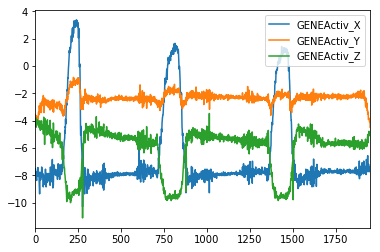

In [24]:
rawdata.iloc[:,1:4].plot()

In [25]:
rawdata.head()

,timestamp,GENEActiv_X,GENEActiv_Y,GENEActiv_Z,GENEActiv_Magnitude
0,1.434973e+09,-7.51189,-3.56766,-4.28453,9.35489
1,1.434973e+09,-7.55112,-3.95894,-4.05407,9.44077
2,1.434973e+09,-7.86689,-4.15409,-3.78537,9.66817
3,1.434973e+09,-7.86690,-4.27178,-4.13055,9.85889
4,1.434973e+09,-7.90612,-3.88050,-4.36101,9.82769
